In [29]:
import os
import sys
import pandas as pd
import numpy as np
sys.path.append("../../src")
import synapseclient as sc
syn = sc.login()
import utils.query_utils as query
import utils.preprocessing_utils as process
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import synapseclient as sc
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import scipy.stats as stats
from pymatch.Matcher import Matcher
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import scipy.stats as stats
from pymatch.Matcher import Matcher
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors


Welcome, aryton tediarjo!



In [42]:
nn_matched = query.get_file_entity(syn, "syn21435058")
exact_matched = query.get_file_entity(syn, "syn21435062")

In [23]:
def print_pvals_ftest(data, group):
    metadata_df = OHE_data(data)[0]
    OHE_cols = OHE_data(data)[1]
    return QaD_correlation(metadata_df[group], metadata_df[OHE_cols])


def OHE_data(data):
    """
    Function to one-hot encode the metadata
    it will encode factorial and categorical variables (phonetype, gender and versions)
    returns the encoded dataset, and the result of the encoded columns
    """
    metadata_df = data
    metadata_cols = [feat for feat in metadata_df.columns if ("." not in feat) and ("healthCode" not in feat)]
    # metadata_df = pd.concat([metadata_df, pd.get_dummies(metadata_df["version"])], axis = 1) 
    metadata_df = pd.concat([metadata_df, pd.get_dummies(metadata_df["phone_type"], 
                                                         prefix = "OHE_is")], axis = 1) 
    metadata_df = pd.concat([metadata_df, pd.get_dummies(metadata_df["gender"], 
                                                         drop_first = True, 
                                                         prefix = "OHE_is")], axis = 1)
    metadata_df = pd.concat([metadata_df, pd.get_dummies(metadata_df["version"], 
                                                         drop_first = True, 
                                                         prefix = "OHE_is")], axis = 1)
    OHE_meta_cols = [feat for feat in metadata_df.columns if ("OHE" in feat) or ("age" in feat) or ("PD" in feat)]
    return metadata_df, OHE_meta_cols



def PCA_plotter(data, feat_cols, 
                metadata_cols, target):
    
    """
    Function to implement PCA with 2 components, 
    then separate them with a target hue variable to see differences

    returns PCA-1 vs PCA-2 plots of metadata and walking features 
    separated by its groups (PD, version)
    """   
    scaler = StandardScaler()
    X_feat = data[feat_cols]
    X_metadata = data[metadata_cols]
    y = data[["version", "healthCode", "PD"]]
    
    lr = LogisticRegression(random_state = 100)
    gb = GradientBoostingClassifier(random_state = 100)
    X_train, X_test, y_train, y_test = train_test_split(X_feat, y[target],
                                                        test_size = 0.2,
                                                        random_state = 100)
    
    gb.fit(X_train, y_train)
    
    print("#################### ASSESSMENT ON %s ################\n" %target)
    print(classification_report(gb.predict(X_test), y_test))
    
    
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(15,5))
    
    #Plotting the Cumulative Summation of the Explained Variance
    X_scaled = scaler.fit_transform(X_feat)
    pca = PCA().fit(X_scaled)
    pca = PCA(n_components = 3)
    principal_comp = pca.fit_transform(X_scaled)
    principal_df = pd.DataFrame(data = principal_comp)
    principal_df = pd.concat([principal_df, y], axis = 1)
    
    sns.scatterplot(principal_df[0], principal_df[1], 
                    hue = principal_df[target], ax = axes[0])
    axes[0].set_title("PCA plot on Walking Features")
    axes[0].set_ylabel("PC2")
    axes[0].set_xlabel("PC1")
    axes[0].grid()
    
    
    #Plotting the Cumulative Summation of the Explained Variance
    X_scaled = scaler.fit_transform(X_metadata)
    pca = PCA().fit(X_scaled)
    pca = PCA(n_components = 3)
    principal_comp = pca.fit_transform(X_scaled)
    principal_df = pd.DataFrame(data = principal_comp)
    principal_df = pd.concat([principal_df, y], axis = 1)
    
    sns.scatterplot(principal_df[0], principal_df[1], 
                    hue = principal_df[target], ax = axes[1])
    axes[1].set_title("PCA plot on metadata")
    axes[1].set_ylabel("PC2")
    axes[1].set_xlabel("PC1")
    axes[1].grid()
    plt.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1)
    plt.show()

In [64]:
def PCA_plot(target, data):
    
    X_feat = data[["age", "nrecords", "iPhone 4S", "iPhone 5",
            "iPhone 6", "iPhone 6+", "iPhone 6S", "iPhone 6S+",
            "iPhone 7", "iPhone 7+", "iPhone 8","iPhone 8+",
            "iPhone SE", "iPhone X"]].reset_index(drop = True)
    
    target_df = data[target].reset_index(drop = True)
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_feat)
    pca = PCA().fit(X_scaled)
    pca = PCA(n_components = 3)
    principal_comp = pca.fit_transform(X_scaled)
    principal_df = pd.DataFrame(data = principal_comp)
    principal_df = pd.concat([principal_df, target_df], axis = 1)  
    sns.scatterplot(principal_df[0], principal_df[1], 
                hue = principal_df[target])
    plt.title("PCA plot on Walking Features")
    plt.ylabel("PC2")
    plt.xlabel("PC1")
    plt.grid()
    plt.show()

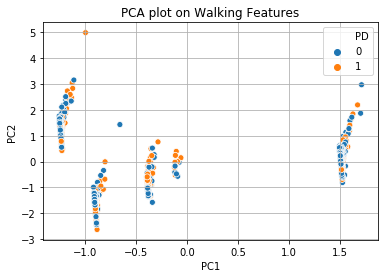

In [66]:
PCA_plot("PD", nn_matched)